# Cài đặt và import thư viện

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations
!pip install --upgrade gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

# Dataset

In [ ]:
import os
from PIL import Image
import numpy as np


def get_files(folder = None, name_filter=None, extension_filter=None):
        if not os.path.isdir(folder):
            raise RuntimeError(f"\"{folder}\" is not a folder.")

        name_cond = (lambda filename: True) if name_filter is None else (lambda filename: name_filter in filename)
        ext_cond = (lambda filename: True) if extension_filter is None else (lambda filename: filename.endswith(extension_filter))

        filtered_files = []

        for path, _, files in os.walk(folder):
            files.sort()
            for file in files:
                if name_cond(file) and ext_cond(file):
                    full_path = os.path.join(path, file)
                    filtered_files.append(full_path)


        return filtered_files

def pil_loader(data_path, label_path):
        """Loads a sample and label image given their path as PIL images.

        Keyword arguments:
        - data_path (``string``): The filepath to the image.
        - label_path (``string``): The filepath to the ground-truth image.

        Returns the image and the label as PIL images.

        """
        data = Image.open(data_path)
        label = Image.open(label_path)
        return data, label

def remap(image, old_values, new_values):
        assert isinstance(image, Image.Image) or isinstance(image, np.ndarray), \
            "image must be of type PIL.Image or numpy.ndarray"
        assert isinstance(new_values, tuple), "new_values must be of type tuple"
        assert isinstance(old_values, tuple), "old_values must be of type tuple"
        assert len(new_values) == len(old_values), "new_values and old_values must have the same length"

        if isinstance(image, Image.Image):
            image = np.array(image)

        tmp = np.zeros_like(image)
        for old, new in zip(old_values, new_values):
            if new != 0:
                tmp[image == old] = new

        return Image.fromarray(tmp)

def enet_weighing(dataloader, num_classes, c=1.02):
        class_count = 0
        total = 0
        for _, label in dataloader:
            label = label.cpu().numpy()
            flat_label = label.flatten()
            class_count += np.bincount(flat_label, minlength=num_classes)
            total += flat_label.size

        propensity_score = class_count / total
        class_weights = 1 / (np.log(c + propensity_score))
        return class_weights

def median_freq_balancing(dataloader, num_classes):
        class_count = 0
        total = 0
        for _, label in dataloader:
            label = label.cpu().numpy()
            flat_label = label.flatten()
            bincount = np.bincount(flat_label, minlength=num_classes)
            mask = bincount > 0
            total += mask * flat_label.size
            class_count += bincount

        freq = class_count / total
        med = np.median(freq)
        return med / freq


In [ ]:
'''
Masks are generated by my own scritps. Mask of all classes in uint8 format means multi hot encoded.
This script tries to segment all types of classes.
Classes are: {'Background':0, 'Water':1, 'Building_No_Damage':2, 'Building_Minor_Damage':3, 'Building_Major_Damage':4, 'Building_Total_Destruction':5,
            'Vehicle':6, 'Road-Clear':7, 'Road-Blocked':8, 'Tree':9, 'Pool':10}
'''

import os
from collections import OrderedDict
import torch.utils.data as data

# @ sh:add
from PIL import Image, ImageOps, ImageFilter
from torchvision import transforms
import numpy as np

class RescueNet(data.Dataset):
    """RescueNet-v2.0 dataset: ....

    Keyword arguments:
    - root_dir (``string``): Root directory path.
    - mode (``string``): The type of dataset: 'train' for training set, 'val'
    for validation set, and 'test' for test set.
    - transform (``callable``, optional): A function/transform that  takes in
    an PIL image and returns a transformed version. Default: None.
    - label_transform (``callable``, optional): A function/transform that takes
    in the target and transforms it. Default: None.
    - loader (``callable``, optional): A function to load an image given its
    path. By default ``default_loader`` is used.

    """
    # Training dataset root folders
    train_folder = "train/train-org-img/"
    train_lbl_folder = "train/train-label-img/"

    # Validation dataset root folders
    val_folder = "val/val-org-img/"
    val_lbl_folder = "val/val-label-img/"

    # Test dataset root folders
    test_folder = "test/test-org-img/"
    test_lbl_folder = "test/test-label-img/"

    # Filters to find the images
    org_img_extension = '.jpg'
    #lbl_name_filter = '.png'

    lbl_img_extension = '.png'
    lbl_name_filter = 'lab'

    # The values associated with the 35 classes
    full_classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
    # The values above are remapped to the following
    new_classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

    # Default encoding for pixel value, class name, and class color
    color_encoding = OrderedDict([
            ('unlabeled', (0, 0, 0)),
            ('water', (61, 230, 250)),
            ('building-no-damage', (180, 120, 120)),
            ('building-medium-damage', (235, 255, 7)),
            ('building-major-damage', (255, 184, 6)),
            ('building-total-destruction', (255, 0, 0)),
            ('vehicle', (255, 0, 245)),
            ('road-clear', (140, 140, 140)),
            ('road-blocked', (160, 150, 20)),
            ('tree', (4, 250, 7)),
            ('pool', (255, 235, 0))
    ])

    def __init__(self,
                 root_dir,
                 mode='train',
                 transform=None,
                 label_transform=None,
                 loader=pil_loader,
                 getfiles=get_files):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.label_transform = label_transform
        self.loader = loader
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.normalize = transforms.Normalize(self.mean, self.std)

        if self.mode.lower() == 'train':
            # Get the training data and labels filepaths
            self.train_data = getfiles(
                os.path.join(root_dir, self.train_folder),
                extension_filter=self.org_img_extension)

            self.train_labels = getfiles(
                os.path.join(root_dir, self.train_lbl_folder),
                name_filter=self.lbl_name_filter,
                extension_filter=self.lbl_img_extension)
        elif self.mode.lower() == 'val':
            # Get the validation data and labels filepaths
            self.val_data = getfiles(
                os.path.join(root_dir, self.val_folder),
                extension_filter=self.org_img_extension)

            self.val_labels = getfiles(
                os.path.join(root_dir, self.val_lbl_folder),
                name_filter=self.lbl_name_filter,
                extension_filter=self.lbl_img_extension)
        elif self.mode.lower() == 'test':
            # Get the test data and labels filepaths
            self.test_data = getfiles(
                os.path.join(root_dir, self.test_folder),
                extension_filter=self.org_img_extension)

            self.test_labels = getfiles(
                os.path.join(root_dir, self.test_lbl_folder),
                name_filter=self.lbl_name_filter,
                extension_filter=self.lbl_img_extension)
        elif self.mode.lower() == 'vis':
            # Get the test data and labels filepaths
            self.test_data = getfiles(
                os.path.join(root_dir, self.test_folder),
                extension_filter=self.org_img_extension)

            self.test_labels = getfiles(
                os.path.join(root_dir, self.test_lbl_folder),
                name_filter=self.lbl_name_filter,
                extension_filter=self.lbl_img_extension)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

    def _normalize(self, image):
        image = image.astype(np.float32)[:, :, ::-1]
        image = image / 255.0
        image -= self.mean
        image /= self.std
        return image

    def __getitem__(self, index):
        """
        Args:
        - index (``int``): index of the item in the dataset

        Returns:
        A tuple of ``PIL.Image`` (image, label) where label is the ground-truth
        of the image.

        """

        if self.mode == 'vis':
            img = Image.open(self.test_data[index]).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            return self.normalize(img), os.path.basename(self.test_data[index])

        if self.mode.lower() == 'train':
            data_path, label_path = self.train_data[index], self.train_labels[
                index]
        elif self.mode.lower() == 'val':
            data_path, label_path = self.val_data[index], self.val_labels[
                index]
        elif self.mode.lower() == 'test':
            data_path, label_path = self.test_data[index], self.test_labels[
                index]
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

        img, label = self.loader(data_path, label_path)

        # Remap class labels
        label = remap(label, self.full_classes, self.new_classes)

        img = np.array(img)
        label = np.array(label)
        if self.transform is not None:
            transformed = self.transform(image=img, mask=label)
            image = transformed["image"]
            label = transformed["mask"].long()

        return image, label

    def __len__(self):
        """Returns the length of the dataset."""
        if self.mode.lower() == 'train':
            return len(self.train_data)
        elif self.mode.lower() == 'val':
            return len(self.val_data)
        elif self.mode.lower() == 'test':
            return len(self.test_data)
        elif self.mode.lower() == 'vis':
            return len(self.test_data)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

In [ ]:
from matplotlib.colors import ListedColormap
color_encoding = OrderedDict([
            ('unlabeled', (0, 0, 0)),
            ('water', (61, 230, 250)),
            ('building-no-damage', (180, 120, 120)),
            ('building-medium-damage', (235, 255, 7)),
            ('building-major-damage', (255, 184, 6)),
            ('building-total-destruction', (255, 0, 0)),
            ('vehicle', (255, 0, 245)),
            ('road-clear', (140, 140, 140)),
            ('road-blocked', (160, 150, 20)),
            ('tree', (4, 250, 7)),
            ('pool', (255, 235, 0))
    ])
color_list = [tuple(c / 255. for c in rgb) for rgb in color_encoding.values()]
cmapMinh = ListedColormap(color_list)

In [ ]:
trainsize = 320

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    # A.RGBShift(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# Noname

Các class trong ảnh: [0 1 2 3 4 5 6 7 8 9]


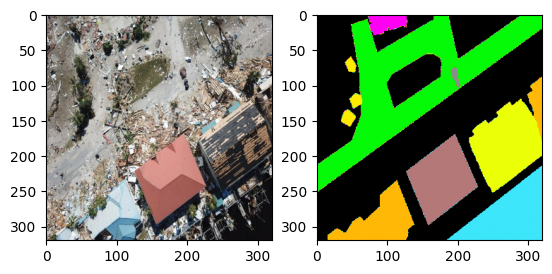

torch.Size([3, 320, 320])
torch.Size([320, 320])


In [ ]:
train_dataset = RescueNet(root_dir='/content/drive/MyDrive/Project_EmbeddedAI/train_code/dataset', transform=train_transform)
test_dataset = RescueNet(root_dir='/content/drive/MyDrive/Project_EmbeddedAI/train_code/dataset',mode = 'val' ,transform=test_trainsform)

image, mask = test_dataset.__getitem__(0)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap = cmapMinh)

classes = np.unique(mask)
print("Các class trong ảnh:", classes)
plt.show()
print(image.shape)
print(mask.shape)


# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision.models as models

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		        nn.BatchNorm2d(ch_out),
			      nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x



class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi



class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        # self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        # self.Up5 = up_conv(ch_in=1024,ch_out=512)
        # self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        # self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        # x5 = self.Maxpool(x4)
        # x5 = self.Conv5(x5)

        # decoding + concat path
        # d5 = self.Up5(x5)
        # x4 = self.Att5(g=d5,x=x4)
        # d5 = torch.cat((x4,d5),dim=1)
        # d5 = self.Up_conv5(d5)

        d4 = self.Up4(x4)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1



# Test model and parameter

In [ ]:
model = AttU_Net(img_ch=3,output_ch=11)

x = torch.rand(4, 3, 320, 320).float()
a = model(x)
print(a.shape)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Tổng số tham số: {total_params}")
print(f"Tham số trainable: {trainable_params}")

torch.Size([4, 11, 320, 320])
Tổng số tham số: 8652276
Tham số trainable: 8652276


# train

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [ ]:
#metrics # IoU
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target


In [ ]:
#device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 16
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)
x, y = testloader.dataset[0]
print(x.shape)

#model
model = AttU_Net(img_ch=3, output_ch=11).to(device)
#model.load_state_dict(torch.load(f'/content/drive/MyDrive/Project_EmbeddedAI/train_code/weight/model_epoch_22.pth', map_location=torch.device('cpu')))

#loss
criterion = nn.CrossEntropyLoss(ignore_index=255)

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 100

#metrics
# dice_fn = DiceScore(num_classes=11, average="macro").to(device)

#meter
# dice_meter = AverageMeter()
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()

num_workers = 2
torch.Size([3, 320, 320])


In [ ]:
for ep in range(23, 1+n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    model.train()

    for batch_id, (x, y) in tqdm(enumerate(trainloader),total = len(trainloader), desc=f'Epoch {ep}/{n_eps}'):
        x = x.to(device)
        y = y.to(device).long()

        #forward
        optimizer.zero_grad()
        outputs = model(x)


        # Tính loss
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # Cập nhật các metric
        train_loss_meter.update(loss.item(), x.size(0))

        # Tính Intersection over Union (IoU) cho từng batch
        # Giả sử bạn đã có function tính IoU như sau
        with torch.no_grad():
          outputs = outputs.argmax(dim=1) # (B,C,H,W) -> (B,H,W)
          intersection, union, target = intersectionAndUnionGPU(outputs.float(), y.float(), 11)
          intersection_meter.update(intersection, x.size(0))
          union_meter.update(union, x.size(0))
          target_meter.update(target, x.size(0))

          # dice_score = dice_fn(outputs, y)
          # dice_meter.update(dice_score.item(), x.size(0))


    #Tính Intersection over Union (IoU) cho tất cả các batch trong epoch
    with torch.no_grad():
      iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)  # vector 21D (cho mỗi lớp)

      mIoU = torch.mean(iou_class)  # mean IoU cho tất cả các lớp'

    # In thông tin kết quả mỗi epoch
    print(f"Epoch {ep}/{n_eps}, Loss: {train_loss_meter.avg:.4f}, IoU: {mIoU:.4f}")

    # Optional: Lưu model sau mỗi epoch
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Project_EmbeddedAI/train_code/weight/model_epoch_{ep}.pth')

# Kết thúc huấn luyện
print("Training finished!")

Epoch 23/100: 100%|██████████| 225/225 [09:01<00:00,  2.41s/it]


Epoch 23/100, Loss: 0.5176, IoU: 0.4192


Epoch 24/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 24/100, Loss: 0.5097, IoU: 0.4269


Epoch 25/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 25/100, Loss: 0.5069, IoU: 0.4291


Epoch 26/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 26/100, Loss: 0.4920, IoU: 0.4369


Epoch 27/100: 100%|██████████| 225/225 [06:18<00:00,  1.68s/it]

Epoch 27/100, Loss: 0.4835, IoU: 0.4433



Epoch 28/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 28/100, Loss: 0.4870, IoU: 0.4423


Epoch 29/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 29/100, Loss: 0.4724, IoU: 0.4523


Epoch 30/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]

Epoch 30/100, Loss: 0.4681, IoU: 0.4563



Epoch 31/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 31/100, Loss: 0.4642, IoU: 0.4582


Epoch 32/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 32/100, Loss: 0.4512, IoU: 0.4684


Epoch 33/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 33/100, Loss: 0.4563, IoU: 0.4667


Epoch 34/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 34/100, Loss: 0.4451, IoU: 0.4730


Epoch 35/100: 100%|██████████| 225/225 [06:17<00:00,  1.68s/it]


Epoch 35/100, Loss: 0.4394, IoU: 0.4776


Epoch 36/100: 100%|██████████| 225/225 [06:48<00:00,  1.82s/it]


Epoch 36/100, Loss: 0.4295, IoU: 0.4846


Epoch 37/100: 100%|██████████| 225/225 [06:18<00:00,  1.68s/it]


Epoch 37/100, Loss: 0.4371, IoU: 0.4842


Epoch 38/100:  49%|████▉     | 110/225 [03:05<03:12,  1.68s/it]

# Test sau khi train xong


Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].


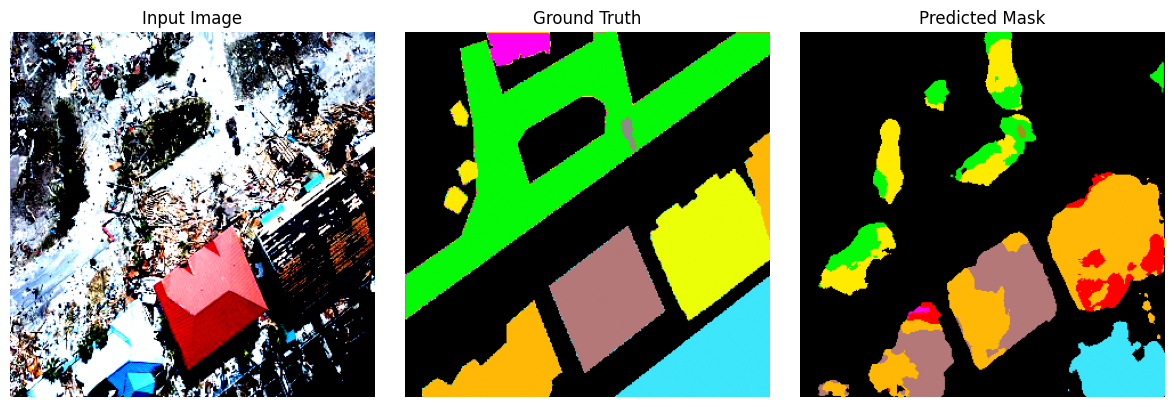

Evaluating:   0%|          | 0/29 [00:06<?, ?it/s]


Mean F1 Score: 0.3886, IoU: 0.3833


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm

model.eval()
f1_scores = []

with torch.no_grad():
    for images, masks in tqdm(testloader, desc="Evaluating"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # (B, C, H, W)
        preds = outputs.argmax(dim=1) # (B,C,H,W) -> (B,H,W)

        show_prediction(images, masks, preds, idx=0)

        # Tính IoU
        intersection, union, target = intersectionAndUnionGPU(preds.float(), masks.float(), 11)
        intersection_meter.update(intersection, images.size(0))
        union_meter.update(union, images.size(0))
        target_meter.update(target, images.size(0))


        # Flatten to (B*H*W,) for F1
        preds_flat = preds.view(-1).cpu().numpy()
        masks_flat = masks.view(-1).cpu().numpy()

        f1 = f1_score(masks_flat, preds_flat, average='macro')  # or 'micro' or 'weighted'
        f1_scores.append(f1)
        break

        # f1_per_class = f1_score(masks_flat, preds_flat, average=None)
        # print(f"\nF1 per class: {f1_per_class}")

iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)  # vector 21D (cho mỗi lớp)
mIoU = torch.mean(iou_class)  # mean IoU cho tất cả các lớp'

mean_f1 = np.mean(f1_scores)
print(f"\nMean F1 Score: {mean_f1:.4f}, IoU: {mIoU:.4f}")


In [ ]:
import matplotlib.pyplot as plt

def show_prediction(image, mask, pred, idx=0):
    """
    Hiển thị ảnh gốc, ground truth mask, và predicted mask.
    image: Tensor (B, C, H, W)
    mask: Tensor (B, H, W)
    pred: Tensor (B, H, W)
    idx: ảnh thứ idx trong batch
    """
    img = image[idx].cpu().permute(1, 2, 0).numpy()  # (H, W, C)
    gt_mask = mask[idx].cpu().numpy()
    pred_mask = pred[idx].cpu().numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap=cmapMinh)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap=cmapMinh)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()